In [1]:
import os
import glob
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import random
%matplotlib inline

### configure your aws credentials to get writerights on S3

In [2]:
home = os.getcwd().split('AUT-CNN-TUB')[0]

# Image cerntering

In [3]:
def get_all_images_from_part(read_path, partname, extension):

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    pats_path = [x.string for x in numbers if x is not None]

    if pats_path == []:
        print('ERROR: no directoris in path or wrong naming')
        SystemExit
        
    if partname not in pats_path:
        if type(partname) is str:
            print("ERROR: dir for this partnumber doesn't exists" )
            SystemExit
        else:
            partname = str(partname)
            
            if partname not in pats_path:
                print("ERROR: dir for this partnumber doesn't exists")
                SystemExit
                
    if extension  not in ['gif', 'jpeg', 'jpg', 'png', 'JPG']:
        print('ERROR: unknown extension')
        SystemExit
        
    else:
        data_path = os.path.join(os.path.join(read_path, partname), '*{}'.format(extension))
        files = glob.glob(data_path)
        return files

In [7]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry/')

In [8]:
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
[x.string for x in numbers if x is not None]

['2',
 '13',
 '14',
 '1',
 '7.1',
 '8',
 '5',
 '4',
 '3',
 '10',
 '12',
 '11',
 '6',
 '7.2',
 '15',
 '9']

In [9]:
files = get_all_images_from_part(read_path, 1, 'jpg')

In [10]:
file_path = files[1]
img_name = file_path.split('/')[-1]  
image = cv2.imread(file_path)

### original

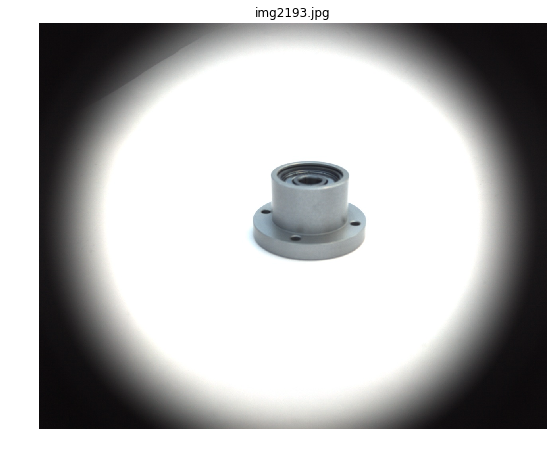

In [11]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(image, cmap='gray');
#ax2 = fig.add_subplot(1, 2, 2)
#ax2.axis('off')
#ax2.set_title('Gaussian interpolation:\n' + file_path.split('/')[-1])
#ax2.imshow(image, cmap='gray', interpolation="gaussian");
plt.show()

### blurred

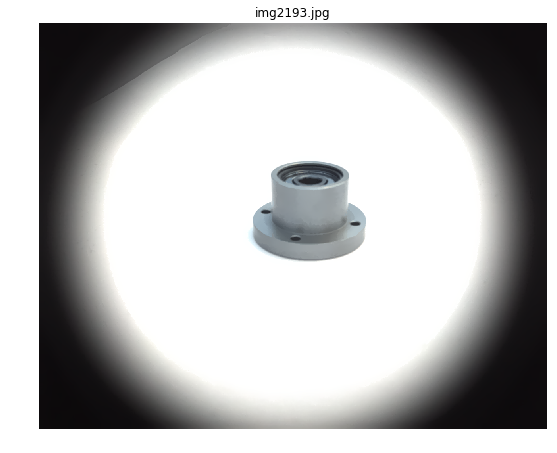

In [12]:
blurred = cv2.pyrMeanShiftFiltering(image, 10, 10)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(blurred)
plt.show()

### grayscale

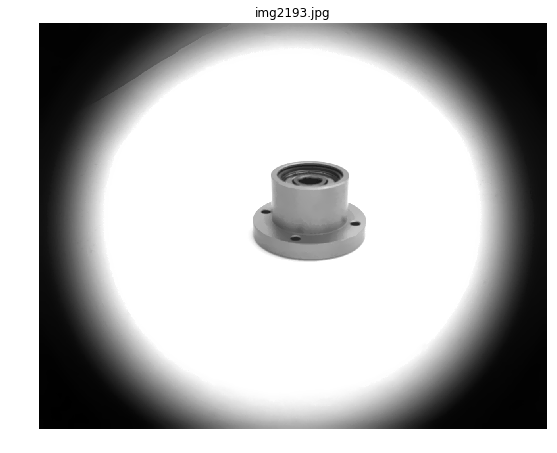

In [13]:
imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(imgray, cmap='gray');
plt.show()

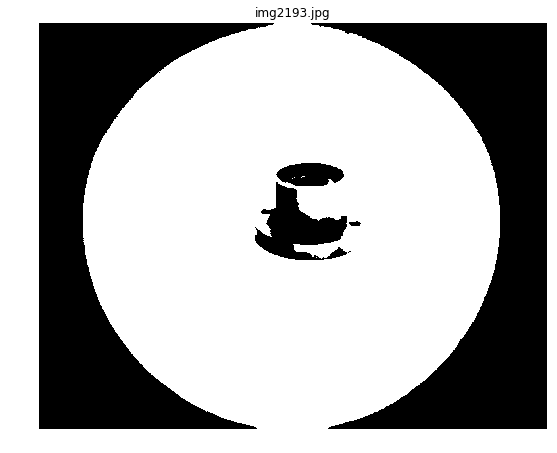

In [14]:
ret,thresh = cv2.threshold(imgray,157,255,0)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh, cmap='gray');
plt.show()

### findContours 

In [15]:
_,contours,_ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours
contour_indexer = 0
i = 0
filteredContours = []
for c in cnt:
    if len(c) > 50:
        filteredContours.append(c)
    if len(filteredContours) > 0:
        merged_contours = np.concatenate(filteredContours)
    else:
        merged_contours = None

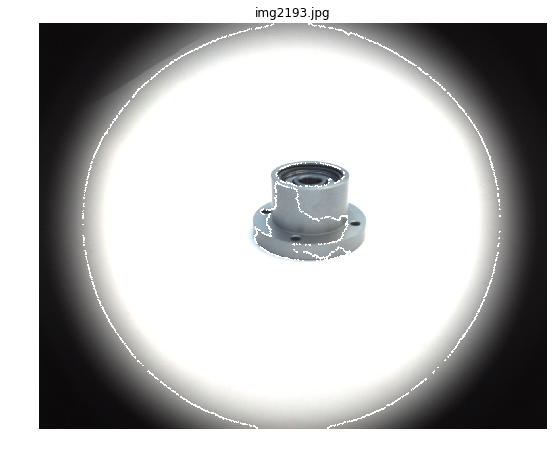

In [16]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.drawContours(image, merged_contours, -3, (255,255,255), 3), cmap='gray');
plt.show()

### fit in circle, to know where to cut

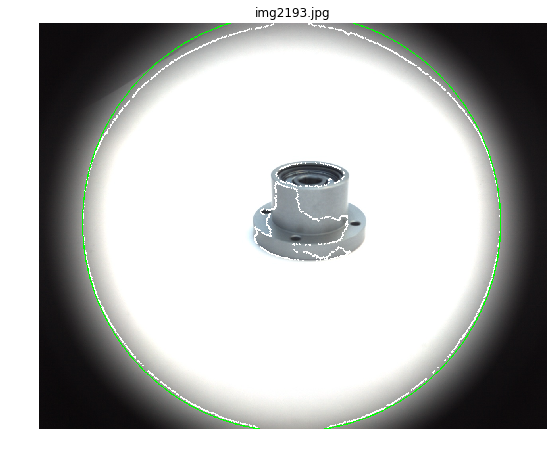

In [17]:
(x,y),radius = cv2.minEnclosingCircle(merged_contours)
center = (int(x),int(y))
radius = int(radius)
img = cv2.circle(image,center,radius,(0,255,0),2)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img)
plt.show()

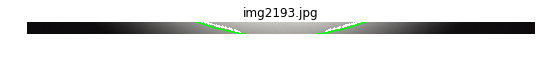

In [18]:
scale = 1.2

scaled_rad = radius * scale
try:
    img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                       center[0] - scaled_rad : center[0] + scaled_rad,
                       : ] 
except:
    img_cutted = image[center[1] - radius : center[1] + radius,
                       center[0] - radius : center[0] + radius,
                       : ] 
    
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img_cutted)
plt.show()

In [9]:
def get_part_from_image(image, scale = 1.3):
    blurred = cv2.pyrMeanShiftFiltering(image, 10, 10)
    imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,157,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours
    contour_indexer = 0
    i = 0
    #for c in cnt[1:]:
    #    i = i + 1
    #    if len(c)>len(cnt[contour_indexer]):
    #        contour_indexer = i
    filteredContours = []
    for c in cnt:
        if len(c) > 50:
            filteredContours.append(c)

    if len(filteredContours) > 0:
        merged_contours = np.concatenate(filteredContours)

        (x,y),radius = cv2.minEnclosingCircle(merged_contours)
        center = (int(x),int(y))
        radius = int(radius)
        scaled_rad = int(radius * scale)
        try:
            img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                               center[0] - scaled_rad : center[0] + scaled_rad,
                               : ] 
        except:
            img_cutted = image[center[1] - radius : center[1] + radius,
                               center[0] - radius : center[0] + radius,
                               : ] 

        return img_cutted
    else:
        return None

0 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01010860.jpg


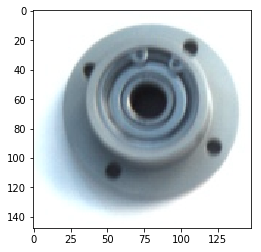

1 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01011254.jpg


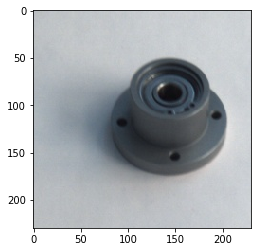

2 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01010322.jpg


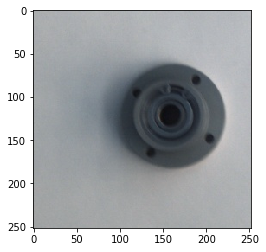

3 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01010645.jpg


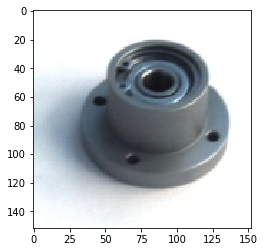

4 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01011138.jpg


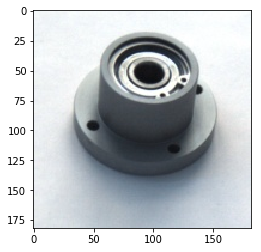

5 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01011379.jpg


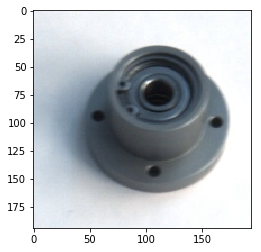

6 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01010973.jpg


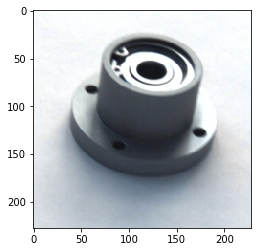

7 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01010124.jpg


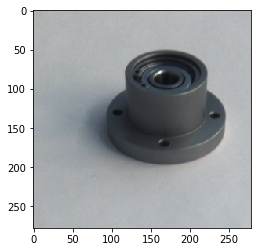

8 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01011413.jpg


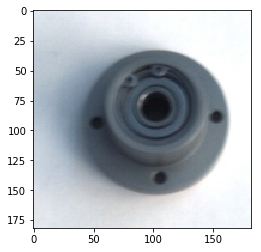

9 /home/jeronimo/git/AUT-CNN-TUB/Data/Datensatz/1/01011292.jpg


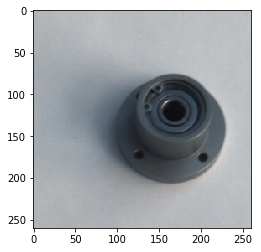

In [10]:
for i, file_path in enumerate(files[:10]):
    image = cv2.imread(file_path)
    print(i,file_path)
    try:
        plt.imshow(get_part_from_image(image))
        plt.show()
    except:
        print('ERROR')

### genrate folder whith cerndered and well shaped images

In [64]:
new_size = 100

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/Raw_Data/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

for part_nr in ['7.2']:#[x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].split('.')[0]
        image = cv2.imread(file_path)
        #try:
        img_centerd = get_part_from_image(image)
        if img_centerd is not None:
            try:
                img_resized = cv2.resize(img_centerd,(new_size, new_size))
            except:
                print('Image {}.jpg is to small.'.format(img_name))

                
            part_patch =os.path.join(write_path, part_nr)
            
            if img_resized is not None:
                if img_resized.var() > 1000:
                    if os.path.exists(part_patch):
                        cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                    else:
                        os.makedirs(part_patch)
                        cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                else:
                    print('Image {}.jpg does not have the necessary variance.'.format(img_name))


Image 072010949.jpg does not have the necessary variance.
Image 072010030.jpg does not have the necessary variance.
Image 072010669.jpg does not have the necessary variance.
Image 072010938.jpg does not have the necessary variance.
Image 072010434.jpg does not have the necessary variance.
Image 072011029.jpg does not have the necessary variance.
Image 072020095.jpg does not have the necessary variance.
Image 072010493.jpg does not have the necessary variance.
Image 072011318.jpg is to small.
Image 072011193.jpg does not have the necessary variance.
Image 072010461.jpg does not have the necessary variance.
Image 072010967.jpg does not have the necessary variance.
Image 072011110.jpg does not have the necessary variance.
Image 072010301.jpg does not have the necessary variance.
Image 072010895.jpg does not have the necessary variance.
Image 072011373.jpg does not have the necessary variance.
Image 072010903.jpg does not have the necessary variance.
Image 072011319.jpg does not have the n

Image 072010602.jpg is to small.
Image 072020083.jpg does not have the necessary variance.
Image 072010821.jpg does not have the necessary variance.
Image 072010710.jpg does not have the necessary variance.
Image 072020045.jpg is to small.
Image 072010818.jpg does not have the necessary variance.
Image 072010010.jpg does not have the necessary variance.
Image 072020202.jpg does not have the necessary variance.
Image 072020051.jpg does not have the necessary variance.
Image 072010103.jpg is to small.
Image 072020030.jpg does not have the necessary variance.
Image 072010563.jpg does not have the necessary variance.
Image 072010692.jpg does not have the necessary variance.
Image 072020072.jpg does not have the necessary variance.
Image 072010279.jpg does not have the necessary variance.
Image 072010055.jpg does not have the necessary variance.
Image 072010396.jpg does not have the necessary variance.
Image 072011228.jpg does not have the necessary variance.
Image 072010433.jpg does not ha

Image 072010757.jpg does not have the necessary variance.
Image 072010129.jpg does not have the necessary variance.
Image 072010793.jpg is to small.
Image 072020075.jpg does not have the necessary variance.
Image 072010672.jpg does not have the necessary variance.
Image 072011391.jpg does not have the necessary variance.
Image 072010440.jpg does not have the necessary variance.
Image 072011129.jpg does not have the necessary variance.
Image 072010132.jpg does not have the necessary variance.
Image 072010612.jpg does not have the necessary variance.
Image 072020105.jpg is to small.
Image 072020187.jpg does not have the necessary variance.
Image 072020100.jpg does not have the necessary variance.
Image 072011090.jpg does not have the necessary variance.
Image 072010064.jpg does not have the necessary variance.
Image 072010837.jpg does not have the necessary variance.
Image 072020081.jpg does not have the necessary variance.
Image 072020197.jpg does not have the necessary variance.
Image 

Image 072020193.jpg does not have the necessary variance.
Image 072020062.jpg is to small.
Image 072020017.jpg is to small.
Image 072020086.jpg does not have the necessary variance.
Image 072011196.jpg does not have the necessary variance.
Image 072010609.jpg does not have the necessary variance.
Image 072010896.jpg does not have the necessary variance.
Image 072011169.jpg does not have the necessary variance.
Image 072020056.jpg does not have the necessary variance.
Image 072010496.jpg does not have the necessary variance.
Image 072010272.jpg does not have the necessary variance.
Image 072010888.jpg does not have the necessary variance.
Image 072010127.jpg does not have the necessary variance.
Image 072011122.jpg does not have the necessary variance.
Image 072010624.jpg does not have the necessary variance.
Image 072010183.jpg does not have the necessary variance.
Image 072020174.jpg does not have the necessary variance.
Image 072010158.jpg does not have the necessary variance.
Image 

Image 072010813.jpg does not have the necessary variance.
Image 072010373.jpg does not have the necessary variance.
Image 072010932.jpg does not have the necessary variance.
Image 072010930.jpg does not have the necessary variance.
Image 072011134.jpg does not have the necessary variance.
Image 072020110.jpg does not have the necessary variance.
Image 072020169.jpg does not have the necessary variance.
Image 072011242.jpg does not have the necessary variance.
Image 072011107.jpg does not have the necessary variance.
Image 072010881.jpg does not have the necessary variance.
Image 072010306.jpg does not have the necessary variance.
Image 072011400.jpg does not have the necessary variance.
Image 072020063.jpg is to small.
Image 072020063.jpg does not have the necessary variance.
Image 072020036.jpg does not have the necessary variance.
Image 072011116.jpg does not have the necessary variance.
Image 072011083.jpg does not have the necessary variance.
Image 072010202.jpg does not have the n

### downscale

In [65]:
new_size = 50

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_100x100/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].split('.')[0]
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

In [68]:
new_size = 28

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_100x100/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].split('.')[0]
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)



### summarize

In [80]:
home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_100x100/')

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(len(os.listdir(os.path.join(read_path, part_nr))), part_nr))


Images in File
2118	2
2605	1
837	7.1
1081	4
1435	3
214	6
788	7.2


In [113]:
# random.shuffle(x) # bringt objekte in x in zufällige neue Reihenfolge

read_path = os.path.join(home,'AUT-CNN-TUB/Data/Centered_28x28/')
path_length   = len(read_path) 
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_28/test/')
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_28/train/')

ratio=0.7
img_path=read_path
GRBtoGray = False
extension = 'jpg'


numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    
    files = get_all_images_from_part(read_path, part_nr, extension)            #  ???
    num_imag     = len(files)
    breakpoint   = int(np.round(ratio*num_imag)) # Berechnet aus Teilungsverhältnis und Datenlänge den 'breakpoint'
    Data         = np.arange(0,num_imag)            
    random.shuffle(Data)  
    DataTrain    = Data[:breakpoint]              # Alle Daten bis zum 'breakpoint'-Index
    DataTest     = Data[breakpoint:]               # Alle Daten oberhalb des 'breakpoint'-Index
    
    if os.path.exists(test_path) is False:
        os.makedirs(test_path)
        
    if os.path.exists(train_path) is False:
        os.makedirs(train_path)
    
    for i,f1 in enumerate(files):
        img_name = f1.split('/')[-1]        

        img = cv2.imread(f1)
        if(GRBtoGray == True):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       # Wandelt RGB-Bild in GrauBild


        if(i in DataTrain):
            cv2.imwrite(train_path + img_name, img)  # speichert Bild im Ordner für Trainingsdaten.
        if(i in DataTest):
            cv2.imwrite(test_path + img_name, img)   # speichert Bild im Ordner für Testdaten.
                                                     # HINWEIS: sollte noch auf validation set erweitert werden.


### save zip on S3

In [1]:
import boto3
import botocore

s3 = boto3.resource('s3')
bucket = s3.Bucket('imagesforcnn')

for bucket in s3.buckets.all():
    print(bucket.name)
        
for object in s3.Bucket('imagesforcnn').objects.all():
    print(object)

imagesforcnn
s3.ObjectSummary(bucket_name='imagesforcnn', key='Centered.zip')
s3.ObjectSummary(bucket_name='imagesforcnn', key='Datensatz.zip')


In [2]:
# zip dir 
from_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered/')
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered')

shutil.make_archive(to_dir,
                    'zip',
                    from_dir
                    )

NameError: name 'shutil' is not defined

In [3]:

path = os.path.join(home,'AUT-CNN-TUB/Data/')

from_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered')
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/')
filename = 'Centered'

extension = 'zip'

if extension is 'zip':
    shutil.make_archive(os.path.join(os.path.join(to_dir, filename)), extension, from_dir)

# Upload a new file
data = open(os.path.join(to_dir, filename + '.{}'.format(extension)), 'rb')
print('uploading {}.{} ... '.format(filename, extension), end='\r')
bucket.put_object(Key=filename + '.{}'.format(extension), Body=data)
print('uploading {}.{} finished'.format(filename, extension))


NameError: name 'bucket' is not defined